In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras as k

In [2]:
# Step 1: Reading and Understanding the Data

df = pd.read_csv("X:/musicGenreClassifyer/Data/features_30_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
# understanding the structure of the data
df.shape

(1000, 60)

In [4]:
# the Data Types in the Dataframe
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [5]:
# dropping the first column ‘filename’ as it is unnecessary
df = df.drop(labels='filename', axis=1)

In [6]:
# Step 2: Understanding the Audio Files
audio_recording = "X:/musicGenreClassifyer/Data/genres_original/rock/rock.00019.wav"
data, sr = librosa.load(audio_recording)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [7]:
# Below line loads and decodes the audio as a time series y.
# sr = sampling rate of y. It is the number of samples per second. 20 kHz is the audible range for human beings.
# So it is used as the default value for sr. In this code we are using sr as 45600Hz.
data, sr = librosa.load(audio_recording)
librosa.load(audio_recording, sr=45600)

# "sampling rate" represents the number of samples of audio carried per second. In other words,
# it defines how many data points (samples) are collected in one second of audio. The unit is in Hertz (Hz).

(array([-0.0943629 , -0.13975604, -0.13673367, ...,  0.0715436 ,
         0.08262499,  0.04876837], dtype=float32),
 45600)

In [8]:
# With the help of IPython.display.Audio we can play audio in the notebook. 
# It is a library used for playing the audio in the jupyterlab.

import IPython 
IPython.display.Audio(data, rate=sr)

In [9]:
# Step 3: Visualizing Audio Files

# Plotting raw wave files:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sr, color="#2B4F72")
#librosa.display.waveshow(y=data, sr=sr)
plt.show()

AttributeError: module 'librosa.display' has no attribute 'waveplot'

<Figure size 1200x400 with 0 Axes>

C:\Users\Affaan\AppData\Local\Temp\ipykernel_8588\4041589725.py:12: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')


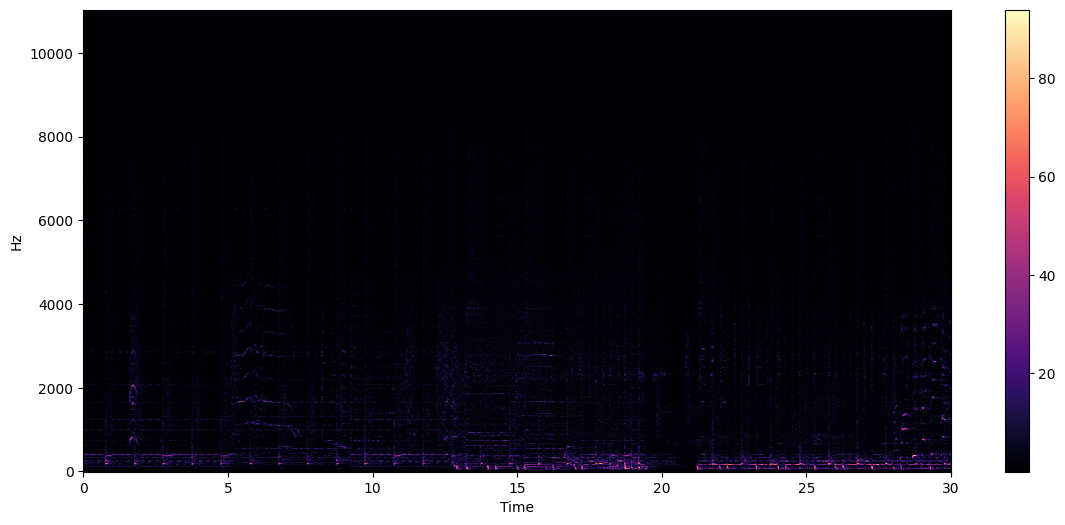

In [10]:
# Spectrograms:

# stft here is computing the Short-Time Fourier Transform (STFT) of an audio signal using librosa.stft()
# The STFT is a technique used in signal processing and time-frequency analysis to represent how the frequency content of a signal changes over time.
stft = librosa.stft(data)

# converting magnitude of stft to Decibels(dB) for better visualization (linear to logarithmic scale)
stft_db = librosa.amplitude_to_db(abs(stft)) 

# linear magnitude of stft
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

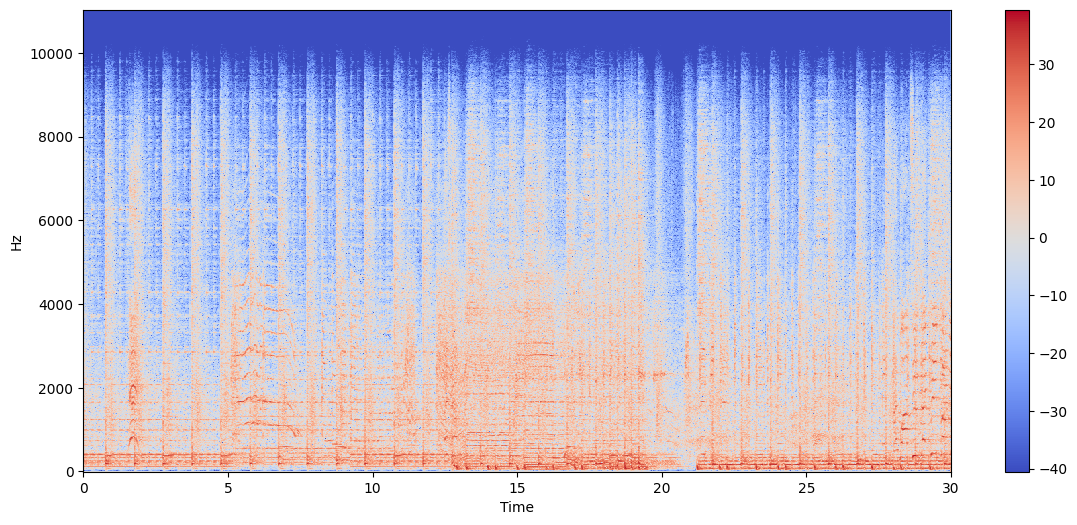

In [11]:
# logarithmic decibel representation of the same
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [12]:
# Spectral Rolloff:

# Spectral Rolloff is the frequency threshold beneath which a designated percentage of the overall spectral energy, such as 70%, is contained.
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sr, alpha=0.4, color="#2B4F72")

TypeError: spectral_rolloff() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given

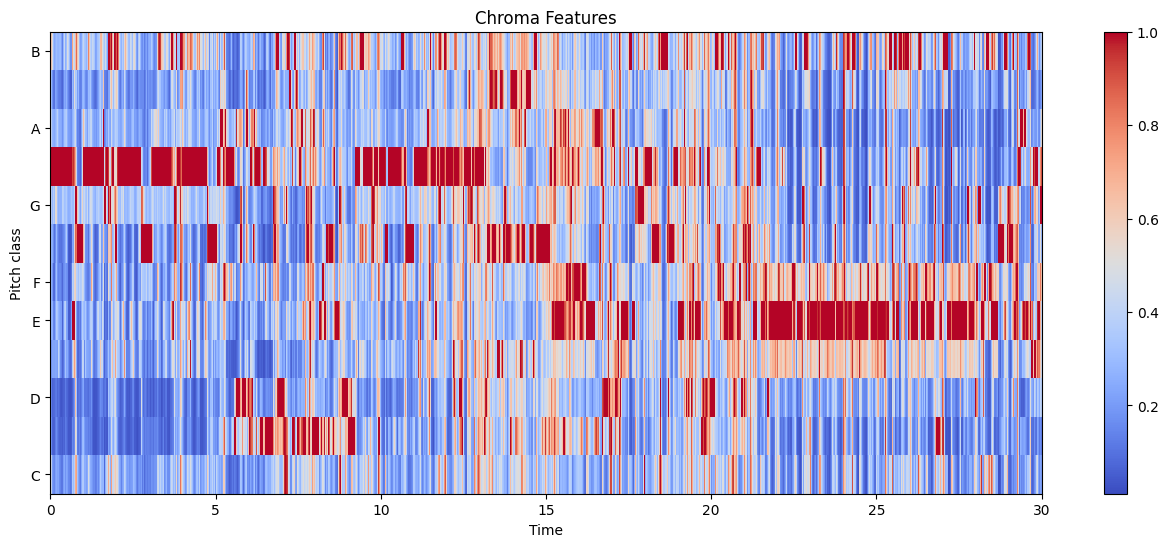

In [13]:
# Chroma Feature: 

# chroma features is that they capture harmonic and melodic characteristics of music while being robust to changes in timbre and instrumentation
# and also used for categorizing pitches
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(y=data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

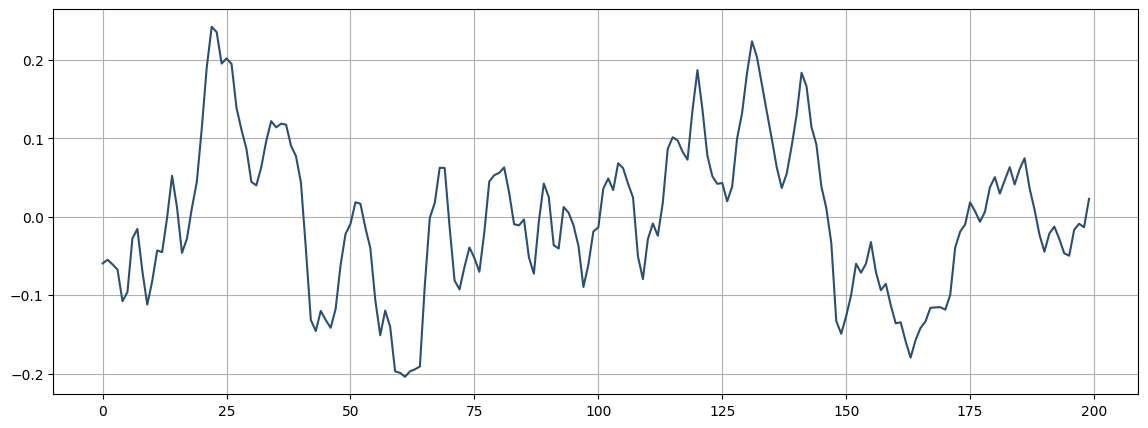

In [14]:
# Zero Crossing Rate:

# The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive.
start = 1000
end = 1200
plt.figure(figsize=(14, 5))
plt.plot(data[start:end], color="#2B4F72")
plt.grid()

In [15]:
# using the librosa library, we can get the count of zero crossings in the audio
zero_cross_rate = librosa.zero_crossings(data[start: end], pad=False)
print("The number of zero-crossings is", sum(zero_cross_rate))

The number of zero-crossings is 23


In [16]:
print(df.iloc[:, -1])

0      blues
1      blues
2      blues
3      blues
4      blues
       ...  
995     rock
996     rock
997     rock
998     rock
999     rock
Name: label, Length: 1000, dtype: object


In [17]:
# Step 4: Feature Extraction

# Preprocessing data, we encode 'label' column with LabelEncoder() of sklearn.preprocessing
# we convert the kind of categorical text data in 'label' into model-understandable numerical data, using the Label Encoder class

def extract_features(df, label_column='label'):
    """
    Extract features from the input DataFrame for music genre classification.

    Parameters:
    - df: pandas DataFrame containing the data.
    - label_column: str, the name of the column containing labels.

    Returns:
    - y: NumPy array, the encoded labels.
    """
    # Check if the specified label column exists in the DataFrame
    if label_column not in df.columns:
        raise ValueError(f"Label column '{label_column}' not found in the DataFrame.")

    # Extract the specified label column from the DataFrame
    class_list = df[label_column]

    # Initialize a LabelEncoder
    convertor = LabelEncoder()

    # fit_transform(): Fit label encoder and return encoded labels.
    y = convertor.fit_transform(class_list)

    # Obtain the unique classes encountered during label encoding
    classes_ = convertor.classes_

    return y, classes_

In [18]:
# call above method to extract encoded labels
encoded_labels, classes = extract_features(df=df, label_column=df.columns[-1])
print(encoded_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [19]:
# Step 5: Scaling the features

# Standardization of a dataset is a common requirement for many machine learning estimators because 
# they might behave worse if the individual features do not more or less look like standard normally distributed data.
from sklearn.preprocessing import StandardScaler

def scale_features(df):
    """
    Scale features of the input DataFrame using StandardScaler.

    Parameters:
    - df: pandas DataFrame containing the data.

    Returns:
    - X_scaled: NumPy array, the standardized features.
    """
    # Extract features excluding the last column (assuming the last column is the target/label)
    X = np.array(df.iloc[:, :-1], dtype=float)

    # Initialize a StandardScaler, used to standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler()

    # Fit and transform the features to obtain standardized values
    X_scaled = scaler.fit_transform(X)

    return X_scaled

In [20]:
# Step 6: Dividing Data Into Training and Testing Sets

X = scale_features(df=df)
y = encoded_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(len(y_train))
print(len(y_test))

# print their types to confirm they are NumPy arrays of integers i.e. they are integer-encoded (for compatobility with the loss function)
print("Data type of y_train:", type(y_train))
print("Data type of y_test:", type(y_test))

670
330
Data type of y_train: <class 'numpy.ndarray'>
Data type of y_test: <class 'numpy.ndarray'>


In [21]:
# Step 7: Building the Model (CNN)

from keras.models import Sequential
#from keras.wrappers.scikit_learn import KerasClassifier

In [22]:

def trainModel (model, epochs, optimizer):
    batch_size = 128
    #callback =  myCallback()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='accuracy')
    
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

In [23]:
def plotValidate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [24]:
model = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout (0.2),
    
    k. layers.Dense (256, activation='relu'),
    k. layers.Dropout (0.2),

    k.layers.Dense (128, activation='relu'),
    k.layers.Dropout (0.2),

    k.layers.Dense (64, activation='relu'),
    k.layers.Dropout (0.2),
    
    k.layers. Dense (10, activation='softmax'),
])

print(model.summary())
model_history = trainModel(model=model, epochs=300, optimizer='adam')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                

In [25]:
# Step 8: Model Evaluation

test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is:", test_loss)
print("\nThe Best test Accuracy is:", test_acc*100)

3/3 [==============================] - 0s 2ms/step - loss: 1.8982 - accuracy: 0.7121
The test Loss is: 1.8981631994247437

The Best test Accuracy is: 71.21211886405945


Validation Accuracy 0.7545454502105713


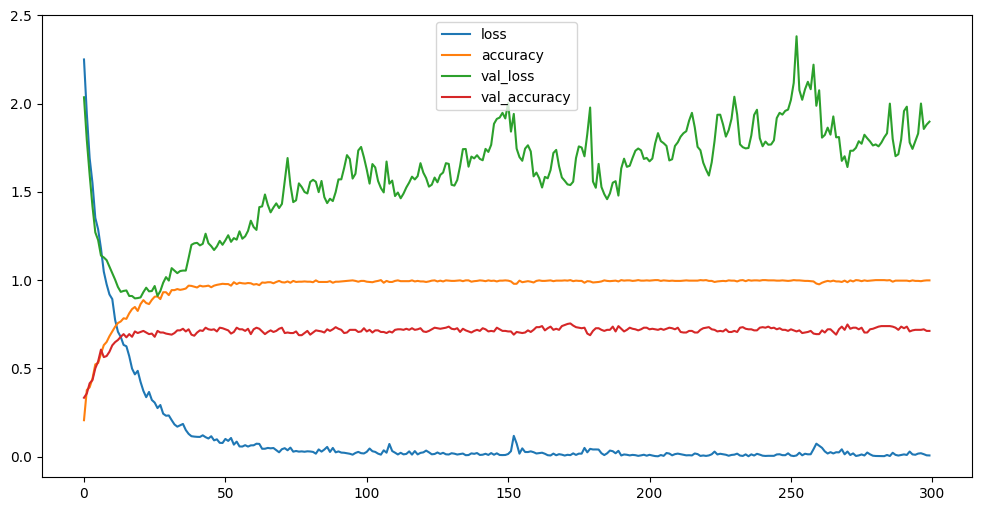

In [26]:
# Visualize Training History 
plotValidate(model_history)

In [27]:
# Step 10: Make Predictions

y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_classes = y_test
y_true_classes = y_true_classes.reshape(-1, 1)

11/11 [==============================] - 0s 798us/step


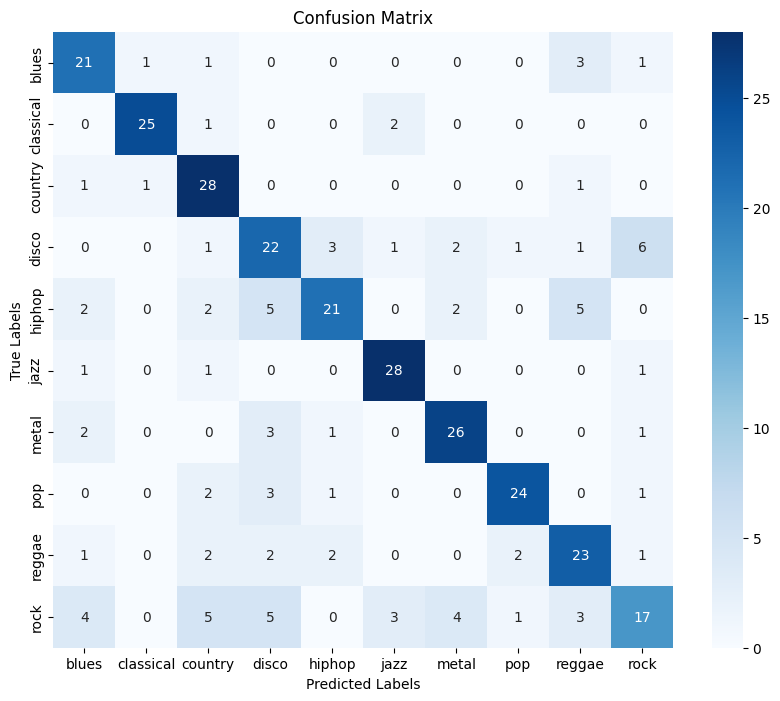

In [28]:
# Step 11: compute and visualize the Confusion Matrix 

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
# classes_ attribute of convertor (instance of LabelEncoder) stores the original class labels
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [29]:
# Step 12: Classification Report

class_report = classification_report(y_true_classes, y_pred_classes, target_names=classes)
print(class_report)

              precision    recall  f1-score   support

       blues       0.66      0.78      0.71        27
   classical       0.93      0.89      0.91        28
     country       0.65      0.90      0.76        31
       disco       0.55      0.59      0.57        37
      hiphop       0.75      0.57      0.65        37
        jazz       0.82      0.90      0.86        31
       metal       0.76      0.79      0.78        33
         pop       0.86      0.77      0.81        31
      reggae       0.64      0.70      0.67        33
        rock       0.61      0.40      0.49        42

    accuracy                           0.71       330
   macro avg       0.72      0.73      0.72       330
weighted avg       0.71      0.71      0.71       330



In [30]:
# Finally save  the trained model after all steps
model.save('genreDetect3.0.h5')

x:\Python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
